In [5]:
from transformers import AutoModelForCausalLM
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import safe as sf
import datamol as dm
from safe.tokenizer import SAFETokenizer

# Load the trained model and tokenizer
checkpoint_path = ".saved_model/phi1_5-safmol_0528/checkpoint-29600"
model = AutoModelForCausalLM.from_pretrained(checkpoint_path)
# Set the model to evaluation mode
model.eval()


/home/thomas/anaconda3/envs/safemol/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(1880, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropo

# Let's make some Molecules!

In [22]:
tokenizer = SAFETokenizer().load(checkpoint_path+"/tokenizer.json")

designer = sf.SAFEDesign(model=model,tokenizer=tokenizer)
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=1000)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/thomas/anaconda3/envs/safemol/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-05-29 09:59:43.218 | INFO     | safe.sample:de_novo_generation:577 - After sanitization, 267 / 1000 (26.70 %) generated molecules are valid !


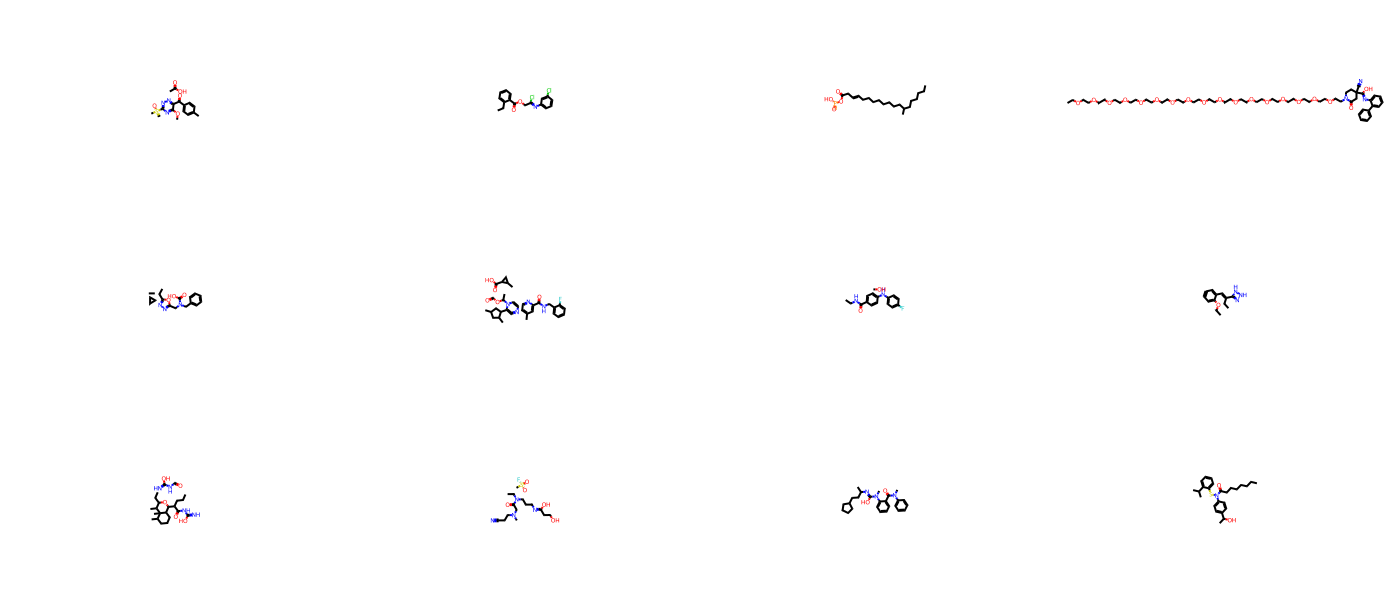

In [23]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


In [24]:
generated_smiles[:10]

['C=S(C)(=O)c1nnc(C(=O)c2ccc(C)cc2)c(OC)n1.CC(=O)O',
 'CCc1ccccc1C(=O)OCC(Cl)=Nc1cccc(Cl)c1',
 'CCCCCCC(C)CCCCCCCCC=CCC(=O)O[PH](=O)O',
 'CCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCN1CCC(C#N)(C(O)=Nc2ccccc2-c2ccccc2)CC1=O',
 'C1CC1.CC.CCc1nnc(CN(Cc2ccccc2)C(=O)O)o1',
 'CC1CC(C)C(C2=C=NC=CN2C(C)OC=O)C1.CC1CC1C(=O)O.Cc1ccnc(C(=O)NCc2ccccc2F)c1',
 'CCNC(=O)c1ccc(Nc2ccc(F)cc2)cc1.CO',
 'CCOc1cc#ccc1C=C(CC)c1n[nH][nH]1',
 'CCCC(C(=O)NC(=N)O)C1OC(CC)C(C)C2(C)C(C)CCCC12.N=C(O)NC=O',
 'CCN(CCCN=C(O)CCO)C(=O)CN(C)CCC#N.CS(=O)(=O)F']

In [25]:
import pandas as pd
train =  pd.read_csv("./data/train.csv")['SMILES'].values
test =  pd.read_csv("./data/test.csv")['SMILES'].values
test_scaffolds = pd.read_csv("./data/test_scaffolds.csv")['SMILES'].values

In [28]:
import moses
metrics = moses.get_all_metrics(gen=generated_smiles,
                                n_jobs = 32, 
                                k=100,
                                train=list(train), 
                                test=test, 
                                test_scaffolds=test_scaffolds)

In [29]:
metrics

{'valid': 1.0,
 'unique@100': 1.0,
 'FCD/Test': 20.80903586605693,
 'SNN/Test': 0.37747693932458254,
 'Frag/Test': 0.7412451146440213,
 'Scaf/Test': 0.14275138783909358,
 'FCD/TestSF': 22.212086871223264,
 'SNN/TestSF': 0.36331454684002124,
 'Frag/TestSF': 0.7425246222605388,
 'Scaf/TestSF': 0.005785989536514324,
 'IntDiv': 0.8748242640529078,
 'IntDiv2': 0.857266251448124,
 'Filters': 0.6816479400749064,
 'logP': 1.836414534766602,
 'SA': 0.7735242422664649,
 'QED': 0.2802537245152669,
 'weight': 83.92526720830142,
 'Novelty': 0.9925093632958801}